In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import numpy as np
df = pd.read_csv(r"C:\Users\vaishu\Desktop\IITH\assignments\PRML\Dataset\BTC-USD.csv")

# Extract specific columns
columns_to_extract = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']  # Replace with your column names
# Assuming 'df' has 'Close' and 'Volume' columns
df['Weighted_Price'] = df['Close'] * df['Volume']
vwap = df['Weighted_Price'].sum() / df['Volume'].sum()
print(f"Volume-Weighted Average Price (VWAP): {vwap}")

df['Date']=pd.to_datetime(df['Date']).dt.tz_localize(None)
# Resample to daily frequency
df_daily = df.resample('D', on='Date').mean()





Volume-Weighted Average Price (VWAP): 27270.705897471114


In [2]:
# Handling missing values in df_daily
df_daily = df_daily.fillna(df_daily.mean())




In [3]:
# Calculate the daily percentage change in Bitcoin price
df_daily['Price_Pct_Change'] = df_daily['Close'].pct_change()




In [4]:
df.head()


,Date,Open,High,Low,Close,Adj_Close,Volume,Weighted_Price
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800,9.629991e+09
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200,1.463605e+10
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700,1.497055e+10
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600,1.507367e+10
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100,1.060070e+10


In [5]:
# Split data into train and test sets
train_size = int(len(df_daily) * 0.9)
train_data, test_data = df_daily[:train_size], df_daily[train_size:]

In [6]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [14]:

import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor

# Create lag features
def create_lagged_features(data, lag=1):
    lagged_data = data.copy()
    for i in range(1, lag+1):
        lagged_data[f'Close_Lag_{i}'] = lagged_data['Close'].shift(i)
    return lagged_data

# Add lagged features to train and test data
lag = 7  # Example: Use the last 5 days' prices as features
train_data_lagged = create_lagged_features(train_data, lag)
test_data_lagged = create_lagged_features(test_data, lag)

# Drop NaN values (as the first 'lag' rows will have NaN values)
train_data_lagged.dropna(inplace=True)
test_data_lagged.dropna(inplace=True)

# Now, the model can use the lag features to make predictions
X_train = train_data_lagged.drop('Close', axis=1)  # Use lagged features as predictors
y_train = train_data_lagged['Close']  # Target is 'Close'
X_test = test_data_lagged.drop('Close', axis=1)
y_test = test_data_lagged['Close']
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1)) 
y_train_scaled=y_train_scaled.ravel()
# Train the Gradient Boosting Regressor model
gbr_model = GradientBoostingRegressor()
gbr_model.fit(X_train_scaled, y_train_scaled)

# Make predictions
gbr_predictions = gbr_model.predict(X_test_scaled)
gbr_predictions = scaler.inverse_transform(gbr_predictions.reshape(-1,1))
print("done")

done


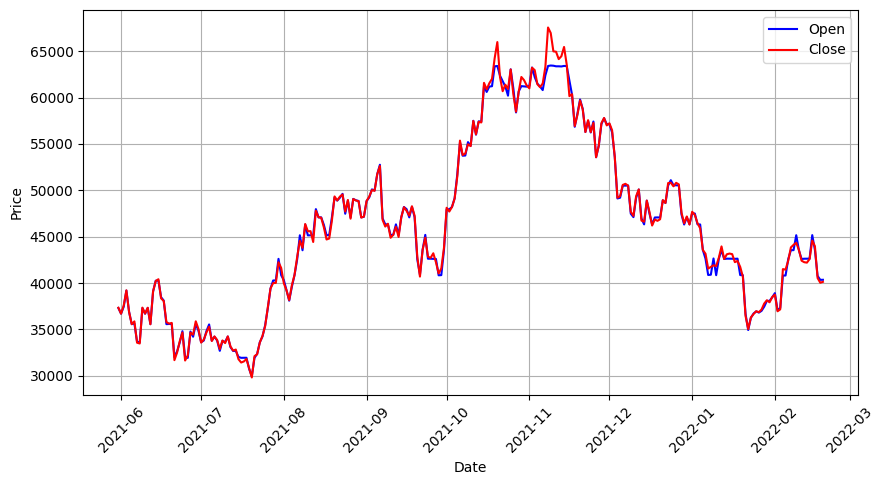

527.0920607196334


In [15]:

plt.figure(figsize=(10, 5))
plt.plot(X_test.index, gbr_predictions,color='blue', label='Open')
plt.plot(y_test.index, y_test, color='red', label='Close')

plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()
gbr_rmse = np.sqrt(mean_squared_error(y_test, gbr_predictions))
print(gbr_rmse)

In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, gbr_predictions)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test, gbr_predictions)

# Root Mean Square Error (RMSE)
rmse = np.sqrt(mse)
gbr_predictions=gbr_predictions.ravel()
# Mean Absolute Percentage Error (MAPE)
# Add a small epsilon to avoid division by zero
epsilon = 1e-10
mape = np.mean(np.abs((y_test - gbr_predictions) / (y_test + epsilon))) * 100

# Symmetric Mean Absolute Percentage Error (sMAPE)
smape = np.mean(2 * np.abs(y_test - gbr_predictions) / (np.abs(y_test) + np.abs(gbr_predictions) + epsilon)) * 100

# Print all metrics
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Square Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Symmetric Mean Absolute Percentage Error (sMAPE): {smape:.2f}%")


Mean Absolute Error (MAE): 264.90
Mean Squared Error (MSE): 261434.14
Root Mean Square Error (RMSE): 511.31
Mean Absolute Percentage Error (MAPE): 0.55%
Symmetric Mean Absolute Percentage Error (sMAPE): 0.55%
